In [1]:
import torchtext
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchtext.vocab import Vectors
from tqdm import tqdm_notebook

In [4]:
text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [9]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes, batch_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes, bias = True)
        self.array_like = np.zeros((batch_size, input_size))
    
    def forward(self, x):
        output = self.linear(x)
        activated = torch.nn.functional.sigmoid(output)
        return activated

    def predict(self, x):
        output = self.forward(x)
        logits = torch.nn.functional.log_softmax(output, dim = 1)
        return logits.max(1)[1] + 1

    def binarize_occurrences(self, indices):
        occurrences = self.array_like.copy()
        for idx, entry in enumerate(indices): occurrences[idx][entry] = 1
        return occurrences

    def batch_to_input(self, batch, train = True):
        word_indices = batch.text.data.numpy().T
        x = self.binarize_occurrences(word_indices)
        if train:
            return torch.FloatTensor(x), batch.label
        else:
            return torch.FloatTensor(x)
    
    def train(self, train_iter, val_iter, num_epochs, learning_rate = 1e-3):
        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in range(1, num_epochs+1):
            epoch_loss = 0
            for batch in train_iter:
                x, y = self.batch_to_input(batch, train = True)
                
                optimizer.zero_grad()
                
                output = self.forward(x)
                
                loss = criterion(output, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.item()
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | Valid acc: {}'.format(epoch, loss_vec[epoch-1], acc))
        
        plt.plot(range(len(loss_vec)), loss_vec)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = self.batch_to_input(batch, train = False), batch.label
            preds = self.predict(x)
            upload += list(preds.data.numpy())
            trues += list(y.data.numpy())
            
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Test Accuracy:', accuracy)
        
        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = self.batch_to_input(batch, train = False), batch.label
            probs = self.model.predict(x)[:len(y.data.numpy())]
            y_p += list(probs.data.numpy())
            y_t += list(y.data.numpy())
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy

Epoch 1 loss: -0.8370819783021259 | Valid acc: 0.7419724770642202
Epoch 2 loss: -0.9692697405298322 | Valid acc: 0.7649082568807339
Epoch 3 loss: -0.9858822540913014 | Valid acc: 0.7626146788990825
Epoch 4 loss: -0.9919665415335253 | Valid acc: 0.7649082568807339
Epoch 5 loss: -0.994978844602673 | Valid acc: 0.7706422018348624


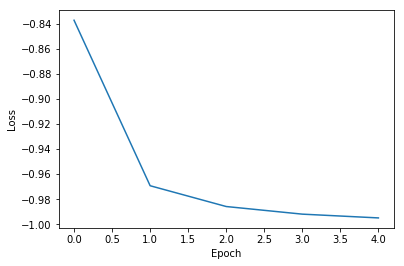


Model trained.

Test Accuracy: 0.7644151565074135


In [10]:
model = LogisticRegression(len(text.vocab), 2, 10)
model.train(train_iter = train_iter, val_iter = val_iter, num_epochs = 5,  learning_rate = 1e-3)
model.test(test_iter)